<a href="https://colab.research.google.com/github/NirSeg/CVLab-2025/blob/main/mnist_ot_passive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MNIST — Passive Phase: Feature Extraction + Optimal Transport (OT)

Extracts a **feature space** for MNIST images and computes **OT-based distances** between datasets:
- **train** (real training set),
- **test** (real test set),
- **gen** (generated set; optional for now, add later).



## 0) Environment



In [1]:
#@title installs

import sys, subprocess, importlib

def pip_install(pkg, import_name=None):
    import_name = import_name or pkg
    try:
        importlib.import_module(import_name)
        print(f"✅ {pkg} already installed.")
    except ImportError:
        print(f"📦 Installing {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        print(f"✅ {pkg} installed successfully.")

# Core
pip_install("torch")
pip_install("torchvision")
pip_install("numpy")
pip_install("matplotlib")

# OT libraries
pip_install("POT", "ot")      # Python Optimal Transport (import as `ot`)
pip_install("geomloss")

print("🎉 Environment ready.")


✅ torch already installed.
✅ torchvision already installed.
✅ numpy already installed.
✅ matplotlib already installed.
📦 Installing POT ...
✅ POT installed successfully.
📦 Installing geomloss ...
✅ geomloss installed successfully.
🎉 Environment ready.



## 1) Data — MNIST loaders (train/test/gen)


In [2]:
#@title Helper functions

# --- Imports ---
import torch, random, os, numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from pathlib import Path

# --- Config ---
train_path, test_path, gen_path = "./data/train_mnist.pt", "./data/test_mnist.pt", "./data/gen_mnist.pt"  # or None
batch_size, gen_k = 512, 2000
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Seed ---
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
set_seed()

# --- Transform for TorchVision fallback ---
T28 = transforms.Compose([transforms.Grayscale(1), transforms.Resize((28,28)), transforms.ToTensor()])

# --- Loader for .pt (expects dict with 'x' and optional 'y', or tensor x) ---
def load_pt(path):
    obj = torch.load(path, map_location="cpu")
    feat, labels = (obj["x"], obj.get("y")) if isinstance(obj, dict) else (obj, None)
    if feat.ndim == 3: feat = feat.unsqueeze(1)
    feat = feat.float() / (255.0 if feat.max() > 1 else 1)
    labels = torch.full((len(feat),), -1, dtype=torch.long) if labels is None else torch.as_tensor(labels).long()
    print(f"[Loaded {path}] -> features:{tuple(feat.shape)} labels:{tuple(labels.shape)} range=({feat.min():.1f},{feat.max():.1f})")
    return TensorDataset(feat.contiguous(), labels.contiguous())

# --- Builders ---
def build(path, train: bool, name="train"):
    if path and Path(path).exists():
        return load_pt(path)
    print(f"[Downloading TorchVision {name}]")
    return datasets.MNIST("./data", train=train, download=True, transform=T28)

def take_first_k(ds, k: int) -> TensorDataset:
    xs, ys = [], []
    loader = DataLoader(ds, batch_size=min(4096, k), shuffle=False)
    cnt = 0
    for xb, yb in loader:
        xs.append(xb); ys.append(yb)
        cnt += len(xb)
        if cnt >= k: break
    feat = torch.cat(xs, 0)[:k]
    labels = torch.cat(ys, 0)[:k].long()
    return TensorDataset(feat, labels)

def build_gen(path, test_ds, k: int, name="gen"):
    if path and Path(path).exists():
        return load_pt(path)
    print(f"[No gen file] -> building '{name}' from test (first {k})")
    # If test_ds already a TensorDataset, just slice:
    if isinstance(test_ds, TensorDataset):
        feat, labels = test_ds.tensors
        feat, labels = feat[:k], labels[:k].long()
        ds = TensorDataset(feat, labels)
    else:
        ds = take_first_k(test_ds, k)
    print(f"[Built gen] features:{tuple(ds.tensors[0].shape)} labels:{tuple(ds.tensors[1].shape)}")
    return ds


In [3]:
#@title Load from `pt` files
train_ds = build(train_path, True, "train")
test_ds  = build(test_path,  False, "test")
gen_ds   = build_gen(gen_path, test_ds, gen_k, "gen")

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  pin_memory=(device=="cuda"))
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, pin_memory=(device=="cuda"))
gen_loader   = DataLoader(gen_ds,   batch_size=batch_size, shuffle=False, pin_memory=(device=="cuda"))

# --- Quick summary ---
print(f"\n[Summary] Train={len(train_ds)}  Test={len(test_ds)}  Gen={len(gen_ds)}  Batch={batch_size}")
xb, yb = next(iter(train_loader))
print(f"[One train batch] features:{tuple(xb.shape)} labels:{tuple(yb.shape)} dtype={xb.dtype} device={xb.device}")
print("Sample labels:", yb[:10].tolist())


[Loaded ./data/train_mnist.pt] -> features:(54912, 1, 28, 28) labels:(54912,) range=(-1.0,1.0)
[Loaded ./data/test_mnist.pt] -> features:(10000, 1, 28, 28) labels:(10000,) range=(-1.0,1.0)
[Loaded ./data/gen_mnist.pt] -> features:(5000, 1, 28, 28) labels:(5000,) range=(0.0,1.0)

[Summary] Train=54912  Test=10000  Gen=5000  Batch=512
[One train batch] features:(512, 1, 28, 28) labels:(512,) dtype=torch.float32 device=cpu
Sample labels: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]



## 2) Feature extractor — SimpleMNISTFeatureNet

A compact CNN encoder sized to MNIST complexity, returning both logits and a **128-D feature** vector.


In [4]:
#@title SimpleMNISTFeatureNet

import torch.nn as nn
import torch.nn.functional as F
import torch

class SimpleMNISTFeatureNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.fc_feat = nn.Linear(64 * 5 * 5, 128)
        self.fc_out = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        feat = F.relu(self.fc_feat(x))
        out = self.fc_out(feat)
        return out, feat

model = SimpleMNISTFeatureNet().to(device)
print("Parameters (k):", sum(p.numel() for p in model.parameters())/1e3)


Parameters (k): 225.034



## 3) Extract features for each set

Generates a matrix `features` of shape `(N, D)` and optional `labels` per set. We also **subsample per class** for fair OT comparisons and speed.


In [5]:
#@title Exact features

# === Config (replaces cfg) ===
batch_size = 512
device = "cuda" if torch.cuda.is_available() else "cpu"

# Fixed target size per domain (can be changed later)
target_per_domain = 5000   # <-- change this to any size you want

# === DataLoaders without multiprocessing workers ===
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                          num_workers=0, pin_memory=False)
gen_loader   = DataLoader(gen_ds,   batch_size=batch_size, shuffle=False,
                          num_workers=0, pin_memory=False) if (gen_ds is not None) else None

# === Feature extraction ===
import torch, numpy as np

@torch.no_grad()
def extract_features(model, loader, device="cpu"):
    """
    Runs the model on a DataLoader and collects features and labels.
    Assumes model(x) -> (logits, features).
    Returns:
        feats:  (N, D) np.ndarray
        labels: (N,)   np.ndarray (int) or None if unavailable
    """
    model.eval()
    feats, labels = [], []
    for batch in loader:
        # Support multiple dataset output formats
        if isinstance(batch, (list, tuple)) and len(batch) == 2:
            x, y = batch
        elif isinstance(batch, dict):
            x, y = batch.get("x"), batch.get("y", -1)
        else:
            x, y = batch, -1

        x = x.to(device)
        logits, feat = model(x)
        feats.append(feat.cpu())
        if not torch.is_tensor(y):
            y = torch.as_tensor(y)
        labels.append(y.clone().cpu())

    feats = torch.cat(feats, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy() if len(labels) > 0 else None
    return feats, labels


def fixed_size_subsample(
    feats: np.ndarray,
    labels: np.ndarray | None,
    size_per_domain: int = 5000,
    num_classes: int = 10,
    balance_by_class: bool = True,
    rng: np.random.Generator | None = None,):

    if rng is None:
        rng = np.random.default_rng()

    N = len(feats)
    if N == 0:
        raise ValueError("feats is empty; cannot subsample.")

    # Case 1: No usable labels -> uniform (over)sample from the whole set
    if (labels is None) or (np.asarray(labels) < 0).all() or (not balance_by_class):
        replace = size_per_domain > N
        sel_idx = rng.choice(N, size=size_per_domain, replace=replace)
        return feats[sel_idx], (labels[sel_idx] if labels is not None else None)

    # Case 2: Balance by class (labels are valid)
    # Compute per-class target. We use ceil to ensure we can fill the budget,
    # then trim any excess at the end.
    quota = int(np.ceil(size_per_domain / num_classes))

    selected_indices = []
    for c in range(num_classes):
        cls_idx = np.where(labels == c)[0]
        if len(cls_idx) == 0:
            # No samples for this class -> skip, we'll fill with other classes later
            continue

        if len(cls_idx) >= quota:
            # Enough samples -> sample without replacement
            pick = rng.choice(cls_idx, size=quota, replace=False)
        else:
            # Not enough -> take all and oversample with replacement to hit the quota
            deficit = quota - len(cls_idx)
            if deficit > 0:
                extra = rng.choice(cls_idx, size=deficit, replace=True)
                pick = np.concatenate([cls_idx, extra], axis=0)
            else:
                pick = cls_idx  # should not happen, but safe
        selected_indices.append(pick)

    if not selected_indices:
        # Edge case: labels exist but no class indices found (shouldn't happen)
        replace = size_per_domain > N
        sel_idx = rng.choice(N, size=size_per_domain, replace=replace)
        return feats[sel_idx], labels[sel_idx]

    sel_idx = np.concatenate(selected_indices, axis=0)

    # If we overshot the size_per_domain (because of ceil or many classes),
    # randomly trim to exact size; if undershot (due to many empty classes), top up uniformly.
    if len(sel_idx) > size_per_domain:
        sel_idx = rng.choice(sel_idx, size=size_per_domain, replace=False)
    elif len(sel_idx) < size_per_domain:
        # Top up from the whole pool (respecting labels distribution implicitly)
        deficit = size_per_domain - len(sel_idx)
        extra = rng.choice(N, size=deficit, replace=(deficit > N))
        sel_idx = np.concatenate([sel_idx, extra], axis=0)

    return feats[sel_idx], labels[sel_idx]


# === Run extraction ===
train_feats, train_labels = extract_features(model, train_loader, device=device)
test_feats,  test_labels  = extract_features(model, test_loader,  device=device)
gen_feats,   gen_labels   = (extract_features(model, gen_loader, device=device)
                             if gen_loader is not None else (None, None))

# === Fixed-size subsampling (exactly target_per_domain each) ===
train_feats_sub, train_labels_sub = fixed_size_subsample(
    train_feats, train_labels, size_per_domain=target_per_domain, num_classes=10, balance_by_class=True)

test_feats_sub, test_labels_sub = fixed_size_subsample(
    test_feats, test_labels, size_per_domain=target_per_domain, num_classes=10, balance_by_class=True)

if gen_feats is not None:
    gen_feats_sub, gen_labels_sub = fixed_size_subsample(
        gen_feats, gen_labels, size_per_domain=target_per_domain, num_classes=10, balance_by_class=True)
else:
    gen_feats_sub, gen_labels_sub = None, None

print("Shapes (full):   ",
      train_feats.shape, test_feats.shape, (None if gen_feats is None else gen_feats.shape))
print("Shapes (fixed):  ",
      train_feats_sub.shape, test_feats_sub.shape, (None if gen_feats_sub is None else gen_feats_sub.shape))


Shapes (full):    (54912, 128) (10000, 128) (5000, 128)
Shapes (fixed):   (5000, 128) (5000, 128) (5000, 128)


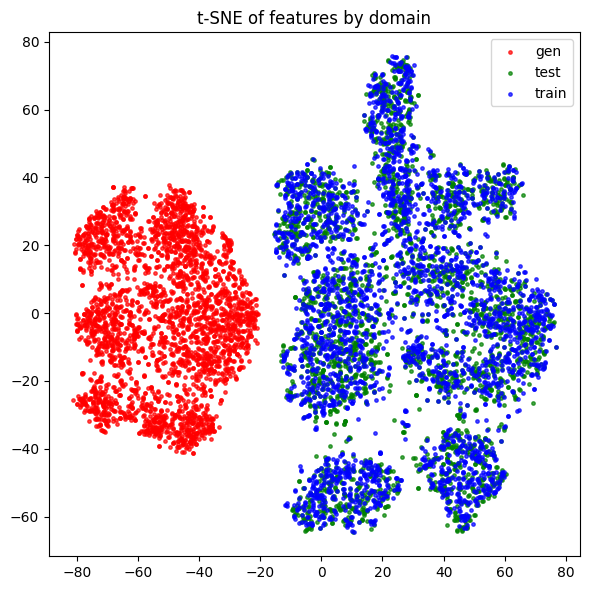

In [6]:
#@title Optional: t-SNE visualization (quick view of feature space). Disable if scikit-learn missing.

try:
    from sklearn.manifold import TSNE
    import numpy as np
    import matplotlib.pyplot as plt

    def sample_for_tsne(feats, labels, per_class=300):
        idxs = []
        if labels is not None and (labels >= 0).any():
            for c in range(10):
                cand = np.where(labels == c)[0]
                if len(cand) == 0:
                    continue
                take = min(per_class, len(cand))
                idxs.append(np.random.choice(cand, size=take, replace=False))
            if idxs:
                idxs = np.concatenate(idxs)
            else:
                idxs = np.random.choice(len(feats), size=min(3000, len(feats)), replace=False)
        else:
            idxs = np.random.choice(len(feats), size=min(3000, len(feats)), replace=False)
        return feats[idxs], (labels[idxs] if labels is not None and (labels >= 0).any() else -np.ones(len(idxs), dtype=int))

    sets = [("train", train_feats_sub, train_labels_sub), ("test", test_feats_sub, test_labels_sub)]
    if gen_feats_sub is not None:
        sets.append(("gen", gen_feats_sub, gen_labels_sub))

    all_feat, all_lab, all_dom = [], [], []
    for name, feats, labels in sets:
        f, l = sample_for_tsne(feats, labels, per_class=200)
        all_feat.append(f)
        all_lab.append(l)
        all_dom += [name] * len(f)
    X = np.concatenate(all_feat, axis=0)
    Y = np.concatenate(all_lab, axis=0)

    X2 = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca').fit_transform(X)

    colors = {"train": "blue", "test": "green", "gen": "red"}

    plt.figure(figsize=(6,6))
    for dom in np.unique(all_dom):
        idxs = [i for i, d in enumerate(all_dom) if d == dom]
        plt.scatter(X2[idxs,0], X2[idxs,1], s=6, c=colors[dom], label=dom, alpha=0.7)

    plt.title("t-SNE of features by domain")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("t-SNE visualization skipped:", e)




## 4) OT distances



In [9]:
!pip install POT

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import ot

In [11]:
#@title sinkhorn

# -------------------------
# Sinkhorn OT cost helper
# -------------------------
def _safe_max(C: np.ndarray) -> float:
    cmax = np.max(C)
    return 1.0 if (not np.isfinite(cmax) or cmax <= 0) else float(cmax)

def sinkhorn_cost(
    X: np.ndarray,
    Y: np.ndarray,
    reg: float = 0.1,
    metric: str = "euclidean",
    nit: int = 100,
    stopThr: float = 1e-9,
) -> float:
    """
    Compute entropic OT cost between X and Y using POT's sinkhorn,
    with the same scaling trick used in your 'official' plan:
      - Build cost matrix C
      - Scale M = C / cmax for numerical stability
      - Run sinkhorn on M
      - Return cost in original units: sum(M * T) * cmax
    """
    n, m = len(X), len(Y)
    a = ot.utils.unif(n).astype(np.float64)
    b = ot.utils.unif(m).astype(np.float64)

    C = ot.dist(X.astype(np.float64), Y.astype(np.float64), metric=metric)
    cmax = _safe_max(C)
    M = C / cmax
    T = ot.sinkhorn(a, b, M, reg=reg, numItermax=nit, stopThr=stopThr)
    cost = float(np.sum(M * T) * cmax)
    return cost

In [12]:
#@title fid

# -------------------------
# FID utilities
# -------------------------
def _cov_and_mean(X: np.ndarray, eps: float = 1e-6):
    """
    Compute covariance (D x D) and mean (D,) for features matrix X of shape (N, D).
    Adds eps*I to covariance for numerical stability.
    """
    X = np.asarray(X, dtype=np.float64)
    mu = np.mean(X, axis=0)
    cov = np.cov(X, rowvar=False)
    d = cov.shape[0]
    cov = cov + eps * np.eye(d, dtype=np.float64)
    return cov, mu

def _trace_sqrt_product(cov1: np.ndarray, cov2: np.ndarray, eps: float = 1e-6) -> float:
    """
    Compute Tr( sqrt( cov1^{1/2} * cov2 * cov1^{1/2} ) ).
    Tries SciPy for best stability; falls back to NumPy-only approach otherwise.
    """
    cov1 = np.asarray(cov1, dtype=np.float64)
    cov2 = np.asarray(cov2, dtype=np.float64)
    try:
        import scipy.linalg as sla  # type: ignore
        w1, V1 = np.linalg.eigh(cov1)
        w1 = np.clip(w1, 0.0, None)
        cov1_sqrt = (V1 * np.sqrt(w1)) @ V1.T
        A = cov1_sqrt @ cov2 @ cov1_sqrt
        A = (A + A.T) * 0.5
        sqrtA = sla.sqrtm(A)
        if np.iscomplexobj(sqrtA):
            sqrtA = sqrtA.real
        return float(np.trace(sqrtA))
    except Exception:
        w1, V1 = np.linalg.eigh(cov1)
        w1 = np.clip(w1, 0.0, None)
        cov1_sqrt = (V1 * np.sqrt(w1)) @ V1.T
        A = cov1_sqrt @ cov2 @ cov1_sqrt
        A = (A + A.T) * 0.5
        wa, _ = np.linalg.eigh(A)
        wa = np.clip(wa, 0.0, None)
        return float(np.sum(np.sqrt(wa + eps)))

def compute_fid(X: np.ndarray, Y: np.ndarray, eps: float = 1e-6) -> float:
    """
    Fréchet distance between feature sets X and Y:
        ||μ1 - μ2||^2 + Tr(Σ1 + Σ2 - 2 * (Σ1^{1/2} Σ2 Σ1^{1/2})^{1/2})
    """
    cov1, mu1 = _cov_and_mean(X, eps=eps)
    cov2, mu2 = _cov_and_mean(Y, eps=eps)
    diff = mu1 - mu2
    trace_term = np.trace(cov1) + np.trace(cov2) - 2.0 * _trace_sqrt_product(cov1, cov2, eps=eps)
    fid = float(diff @ diff + trace_term)
    return max(fid, 0.0)


In [13]:
#@title Noise

# -------------------------
# Noise generation
# -------------------------
def add_gaussian_noise_like(
    base: np.ndarray,
    sigma: float,
    rng: np.random.Generator | None = None,
    per_feature: bool = True,
) -> np.ndarray:
    """
    Return base + noise, where noise ~ N(0, (sigma * scale)^2).
    If per_feature=True, scale equals per-feature std; otherwise a single global std is used.
    """
    if rng is None:
        rng = np.random.default_rng()
    base = np.asarray(base, dtype=np.float64)
    if per_feature:
        scale = np.std(base, axis=0, ddof=1)
        scale[scale == 0] = 1.0  # avoid zero-variance dims
        noise = rng.normal(loc=0.0, scale=sigma * scale, size=base.shape)
    else:
        gstd = float(np.std(base, ddof=1))
        if gstd == 0:
            gstd = 1.0
        noise = rng.normal(loc=0.0, scale=sigma * gstd, size=base.shape)
    return base + noise


# -------------------------
# Size alignment
# -------------------------
def align_equal_sizes(A: np.ndarray, B: np.ndarray, rng: np.random.Generator | None = None):
    """
    Randomly subsample A or B so that both have the same number of rows.
    """
    if rng is None:
        rng = np.random.default_rng()
    nA, nB = len(A), len(B)
    n = min(nA, nB)
    if nA > n:
        idxA = rng.choice(nA, size=n, replace=False)
        A = A[idxA]
    if nB > n:
        idxB = rng.choice(nB, size=n, replace=False)
        B = B[idxB]
    return A, B


# -------------------------
# Main routine: noise sweep
# -------------------------
def noise_sweep_train_vs_dummy_g(
    train_feats: np.ndarray,
    test_feats: np.ndarray,
    noise_levels: np.ndarray | list[float] = np.linspace(0.0, 1.0, 11),
    reg: float = 0.1,
    nit: int = 100,
    metric: str = "euclidean",
    fid_eps: float = 1e-6,
    seed: int | None = 42,
    per_feature_noise: bool = True,
):
    """
    Compare Train vs g' where g' starts from Test and progressively adds Gaussian noise.
    For each noise level, compute:
      - FID(Train, g')
      - Sinkhorn OT cost(Train, g')
    Returns a dict with arrays of metrics and plots the curves.
    """
    rng = np.random.default_rng(seed)

    # Ensure equal sizes (important for fair comparison and uniform marginals)
    train_eq, test_eq = align_equal_sizes(train_feats, test_feats, rng=rng)

    # Pre-allocate metric arrays
    noise_levels = np.array(noise_levels, dtype=float)
    fid_vals = np.zeros_like(noise_levels, dtype=float)
    ot_vals = np.zeros_like(noise_levels, dtype=float)

    # Iterate over noise scales
    for i, sigma in enumerate(noise_levels):
        # g' starts as test, then add noise with given sigma
        g_prime = add_gaussian_noise_like(
            base=test_eq,
            sigma=sigma,
            rng=rng,
            per_feature=per_feature_noise
        )

        # FID and Sinkhorn cost against Train
        fid_vals[i] = compute_fid(train_eq, g_prime, eps=fid_eps)
        ot_vals[i]  = sinkhorn_cost(train_eq, g_prime, reg=reg, metric=metric, nit=nit)

        print(f"[sigma={sigma:.3f}] FID={fid_vals[i]:.6f} | Sinkhorn={ot_vals[i]:.6f}")

    # Plot
    plt.figure(figsize=(7, 5))
    plt.plot(noise_levels, fid_vals, marker='o', label="FID (Train vs g')")
    plt.plot(noise_levels, ot_vals,  marker='s', label="Sinkhorn OT cost (Train vs g')")
    plt.xlabel("Noise level σ (relative scale)")
    plt.ylabel("Distance / Cost (arbitrary units)")
    plt.title("Train vs g' (starting from Test) — FID and Sinkhorn vs noise")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "noise_levels": noise_levels,
        "fid": fid_vals,
        "sinkhorn_cost": ot_vals,
    }


[sigma=0.000] FID=0.000959 | Sinkhorn=0.472955
[sigma=0.100] FID=0.079803 | Sinkhorn=0.562470
[sigma=0.200] FID=0.320737 | Sinkhorn=0.754703
[sigma=0.300] FID=0.705364 | Sinkhorn=0.975727
[sigma=0.400] FID=1.281724 | Sinkhorn=1.229457
[sigma=0.500] FID=1.983416 | Sinkhorn=1.478646
[sigma=0.600] FID=2.839783 | Sinkhorn=1.734837
[sigma=0.700] FID=3.948213 | Sinkhorn=2.017745
[sigma=0.800] FID=5.107843 | Sinkhorn=2.272840
[sigma=0.900] FID=6.450230 | Sinkhorn=2.540406
[sigma=1.000] FID=7.989185 | Sinkhorn=2.816053


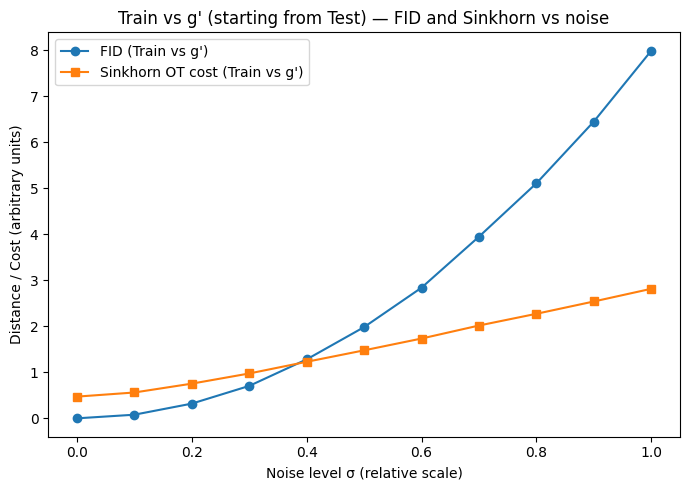

Summary:
sigma=0.000 | FID=0.000959 | Sinkhorn=0.472955
sigma=0.100 | FID=0.079803 | Sinkhorn=0.562470
sigma=0.200 | FID=0.320737 | Sinkhorn=0.754703
sigma=0.300 | FID=0.705364 | Sinkhorn=0.975727
sigma=0.400 | FID=1.281724 | Sinkhorn=1.229457
sigma=0.500 | FID=1.983416 | Sinkhorn=1.478646
sigma=0.600 | FID=2.839783 | Sinkhorn=1.734837
sigma=0.700 | FID=3.948213 | Sinkhorn=2.017745
sigma=0.800 | FID=5.107843 | Sinkhorn=2.272840
sigma=0.900 | FID=6.450230 | Sinkhorn=2.540406
sigma=1.000 | FID=7.989185 | Sinkhorn=2.816053


In [14]:
# -------------------------
# Example call (uses your already-prepared sub-sampled features)
# Assumes: train_feats_sub and test_feats_sub already exist and share the same feature dimension.
# -------------------------
results_noise_sweep = noise_sweep_train_vs_dummy_g(
    train_feats=train_feats_sub,
    test_feats=test_feats_sub,
    noise_levels=np.linspace(0.0, 1.0, 11),  # 0.0 == best case (g' = test), up to σ=1.0
    reg=0.1,
    nit=100,
    metric="euclidean",
    fid_eps=1e-6,
    seed=123,
    per_feature_noise=True,   # set to False to use a single global std for all features
)

print("Summary:")
for s, f, o in zip(results_noise_sweep["noise_levels"], results_noise_sweep["fid"], results_noise_sweep["sinkhorn_cost"]):
    print(f"sigma={s:.3f} | FID={f:.6f} | Sinkhorn={o:.6f}")

[sigma=0.000] FID(Test, g')=0.000959 | Sinkhorn(Test, g')=0.472955
[sigma=0.100] FID(Test, g')=0.068932 | Sinkhorn(Test, g')=0.551860
[sigma=0.200] FID(Test, g')=0.279729 | Sinkhorn(Test, g')=0.727791
[sigma=0.300] FID(Test, g')=0.626058 | Sinkhorn(Test, g')=0.934772
[sigma=0.400] FID(Test, g')=1.130264 | Sinkhorn(Test, g')=1.164880
[sigma=0.500] FID(Test, g')=1.749118 | Sinkhorn(Test, g')=1.397776
[sigma=0.600] FID(Test, g')=2.516321 | Sinkhorn(Test, g')=1.639470
[sigma=0.700] FID(Test, g')=3.427683 | Sinkhorn(Test, g')=1.884112
[sigma=0.800] FID(Test, g')=4.479142 | Sinkhorn(Test, g')=2.133365
[sigma=0.900] FID(Test, g')=5.622620 | Sinkhorn(Test, g')=2.374531
[sigma=1.000] FID(Test, g')=7.044134 | Sinkhorn(Test, g')=2.642688


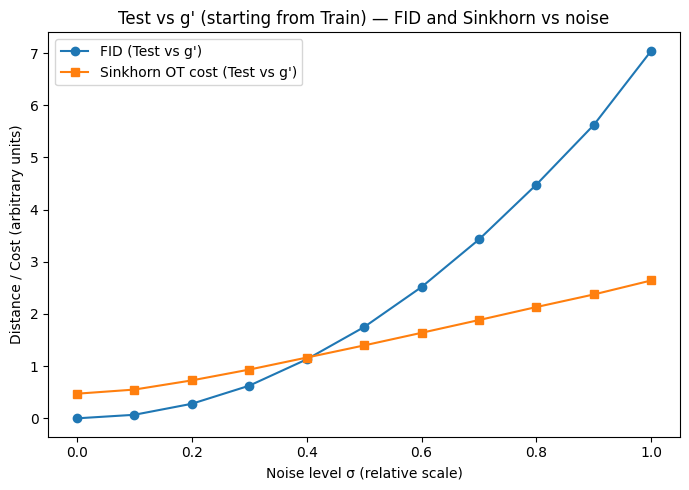

Summary (Part 2):
sigma=0.000 | FID(Test, g')=0.000959 | Sinkhorn(Test, g')=0.472955
sigma=0.100 | FID(Test, g')=0.068932 | Sinkhorn(Test, g')=0.551860
sigma=0.200 | FID(Test, g')=0.279729 | Sinkhorn(Test, g')=0.727791
sigma=0.300 | FID(Test, g')=0.626058 | Sinkhorn(Test, g')=0.934772
sigma=0.400 | FID(Test, g')=1.130264 | Sinkhorn(Test, g')=1.164880
sigma=0.500 | FID(Test, g')=1.749118 | Sinkhorn(Test, g')=1.397776
sigma=0.600 | FID(Test, g')=2.516321 | Sinkhorn(Test, g')=1.639470
sigma=0.700 | FID(Test, g')=3.427683 | Sinkhorn(Test, g')=1.884112
sigma=0.800 | FID(Test, g')=4.479142 | Sinkhorn(Test, g')=2.133365
sigma=0.900 | FID(Test, g')=5.622620 | Sinkhorn(Test, g')=2.374531
sigma=1.000 | FID(Test, g')=7.044134 | Sinkhorn(Test, g')=2.642688


In [15]:
# === Noise-sweep evaluation (Part 2): Test vs g' (starting from Train, add noise) ===
# Uses the same helper functions from Part 1:
#   - compute_fid, sinkhorn_cost, add_gaussian_noise_like, align_equal_sizes

import numpy as np
import matplotlib.pyplot as plt

def noise_sweep_test_vs_noisy_train(
    train_feats: np.ndarray,
    test_feats: np.ndarray,
    noise_levels: np.ndarray | list[float] = np.linspace(0.0, 1.0, 11),
    reg: float = 0.1,
    nit: int = 100,
    metric: str = "euclidean",
    fid_eps: float = 1e-6,
    seed: int | None = 123,
    per_feature_noise: bool = True,
):
    """
    Compare Test vs g' where g' starts from Train and progressively adds Gaussian noise.
    For each noise level sigma:
      - Build g' = Train + noise(sigma)
      - Compute FID(Test, g')
      - Compute Sinkhorn OT cost(Test, g')
    Returns a dict with arrays of metrics and plots the curves.

    Notes:
      * We align sizes of Train and Test for fair comparison and uniform OT marginals.
      * Noise can be per-feature scaled (default) or global (set per_feature_noise=False).
    """
    rng = np.random.default_rng(seed)

    # Ensure equal sizes across sets
    train_eq, test_eq = align_equal_sizes(train_feats, test_feats, rng=rng)

    noise_levels = np.asarray(noise_levels, dtype=float)
    fid_vals = np.zeros_like(noise_levels, dtype=float)
    ot_vals  = np.zeros_like(noise_levels, dtype=float)

    for i, sigma in enumerate(noise_levels):
        # g' starts from train, then add noise
        g_prime = add_gaussian_noise_like(
            base=train_eq,
            sigma=sigma,
            rng=rng,
            per_feature=per_feature_noise
        )

        # Distances vs Test
        fid_vals[i] = compute_fid(test_eq, g_prime, eps=fid_eps)
        ot_vals[i]  = sinkhorn_cost(test_eq, g_prime, reg=reg, metric=metric, nit=nit)

        print(f"[sigma={sigma:.3f}] FID(Test, g')={fid_vals[i]:.6f} | "
              f"Sinkhorn(Test, g')={ot_vals[i]:.6f}")

    # Plot curves
    plt.figure(figsize=(7, 5))
    plt.plot(noise_levels, fid_vals, marker='o', label="FID (Test vs g')")
    plt.plot(noise_levels, ot_vals,  marker='s', label="Sinkhorn OT cost (Test vs g')")
    plt.xlabel("Noise level σ (relative scale)")
    plt.ylabel("Distance / Cost (arbitrary units)")
    plt.title("Test vs g' (starting from Train) — FID and Sinkhorn vs noise")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "noise_levels": noise_levels,
        "fid": fid_vals,
        "sinkhorn_cost": ot_vals,
    }

# --- Example call (uses your sub-sampled features already in memory) ---
results_noise_sweep_part2 = noise_sweep_test_vs_noisy_train(
    train_feats=train_feats_sub,
    test_feats=test_feats_sub,
    noise_levels=np.linspace(0.0, 1.0, 11),  # starts at best case: g' = train (sigma=0)
    reg=0.1,
    nit=100,
    metric="euclidean",
    fid_eps=1e-6,
    seed=321,
    per_feature_noise=True,
)

print("Summary (Part 2):")
for s, f, o in zip(results_noise_sweep_part2["noise_levels"],
                   results_noise_sweep_part2["fid"],
                   results_noise_sweep_part2["sinkhorn_cost"]):
    print(f"sigma={s:.3f} | FID(Test, g')={f:.6f} | Sinkhorn(Test, g')={o:.6f}")
